In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import gc
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import preprocessing
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy
from tqdm import tqdm
from scipy.sparse import coo_matrix,hstack
from sklearn.linear_model import Ridge
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import collections
from wordcloud import STOPWORDS
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 18021314-Đặng Chí Trung K63 K1 

# 1.Mô tả bài toán
# 
Bài toán đưa ra yêu cầu xây dựng công cụ gợi ý giá sản phẩm cho người bán dựa trên thương hiệu các mô tả về tình trạng sản phẩm, tên thương hiệu, mô tả sản phẩm,...


Dữ liệu cung cấp 
* train_id or test_id - Danh sách id
* name - tên sản phẩm
* item_condition_id - tình trạng mặt hàng người bán cung cấp
* category_name - loại hàng hóa
* brand_name - thương hiệu
* price - giá cả
* shipping - 1 nếu phí ship do người bán trả 0 là người dùng trả



input là thông tin của mặt hàng

output là giá gợi ý cho người bán

In [ ]:
!apt-get install p7zip
!p7zip -d -f -k /kaggle/input/mercari-price-suggestion-challenge/train.tsv.7z
!p7zip -d -f -k /kaggle/input/mercari-price-suggestion-challenge/test.tsv.7z
!p7zip -d -f -k /kaggle/input/mercari-price-suggestion-challenge/sample_submission.csv.7z
!unzip /kaggle/input/mercari-price-suggestion-challenge/sample_submission_stg2.csv.zip
!unzip /kaggle/input/mercari-price-suggestion-challenge/test_stg2.tsv.zip

In [ ]:
#đọc file
df_train = pd.read_table('train.tsv',sep='\t')
df_test = pd.read_table('test_stg2.tsv',sep='\t')

# 2.Khai phá dữ liệu

In [ ]:
#đọc 5 hàng dữ liệu đầu của file train
df_train.head(5)

In [ ]:
#đọc 5 hàng dữ liệu đầu của file test
df_test.head(5)

Nhận xét: cột brand_name chứa giá trị rỗng

In [ ]:
#khám phá kiểu dữ liệu 
print(df_train.dtypes)
print(df_train.ndim)
print(df_train.shape)
print(df_train.size)

# 3. Xử lý dữ liệu

In [ ]:
#tăng độ tin cậy của giá trị đầu vào
price = df_train['price'].copy()
df_train['price'] = np.log1p(df_train['price'])

In [ ]:
#đếm các giá trị null
df_train.isnull().any()
df_train.isnull().sum()

Các giá trị null nằm ở cột category_name brand_name item_description                             

In [ ]:
#hàm xử lý dữ liệu null
def handle_missing(data):
    data.brand_name.fillna(value="Not known", inplace=True)
    data.item_description.fillna(value="No description given", inplace=True)
    return data

In [ ]:
#chia các danh mục 
def handle_category(category, data):
    cat1=[]
    cat2=[]
    cat3=[]
    for row in category:
        try:
              categories=row.split('/')
        except:
              categories=['','','']
        cat1.append(categories[0])
        cat2.append(categories[1])
        cat3.append(categories[2])
    data['sub1'] = cat1
    data['sub2'] = cat2
    data['sub3'] = cat3

Cột category_name có 3 trường danh mục nên ta chia các danh mục thành sub1, sub2, sub3 

In [ ]:
handle_missing(df_train)
handle_category(df_train['category_name'],df_train)
df_train.isnull().sum()

Lọc các dữ liệu null ở trường dữ liệu train

In [ ]:
handle_category(df_test['category_name'],df_test)
handle_missing(df_test)
df_test.isnull().sum()

Lọc dữ liệu ở tập test

In [ ]:
from nltk.corpus import stopwords

stopwords = stopwords.words('english')
def preprocess_desc(text_col):
    preprocessed_descs = []
    for sentence in tqdm(text_col.values):
        # Replace "carriage return" with "space".
        sent = sentence.replace('\\r', ' ')
        # Replace "quotes" with "space".
        sent = sent.replace('\\"', ' ')
        # Replace "line feed" with "space".
        sent = sent.replace('\\n', ' ')
        # Replace characters between words with "space".
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # Removing stopwords.
        sent = ' '.join(e for e in sent.split() if e not in stopwords)
        preprocessed_descs.append(sent.lower().strip())
    return preprocessed_descs



In [ ]:
df_train['preprocess_item_description'] =preprocess_desc(df_train['item_description'])
df_test['preprocess_item_description'] =preprocess_desc(df_test['item_description'])

# 4.Phân tích dữ liệu

In [ ]:
#các mặt hàng ở trường sub1
count=df_train['sub1'].value_counts()
print(count)
plt.figure(figsize=(15,5))
sns.barplot(count.index,count)
plt.title("số lượng hàng hóa của từng mặt hàng")
plt.xlabel('sub1')
plt.ylabel('Số lượng hàng')
plt.show()

* 3 mặt hàng về phụ nữ làm đẹp và trẻ em chiếm đa số trong tập dữ liệu
* Trong đó mặt hàng dành cho phụ nữ chiếm 600000 sản phẩm 

In [ ]:
#các mặt hàng ở trường sub2
count=df_train['sub2'].value_counts()
print(count)
plt.figure(figsize=(15,5))
sns.barplot(count.index[:10],count[:10])
plt.title("số lượng hàng hóa của từng mặt hàng")
plt.xlabel('sub2')
plt.ylabel('Số lượng hàng')
plt.show()

 3 mặt hàng xuất hiện nhiều nhất athletic apparel, makeup, tops and blouses

In [ ]:
#các mặt hàng ở trường sub3
count=df_train['sub3'].value_counts()
print(count)
plt.figure(figsize=(15,5))
sns.barplot(count.index[:10],count[:10])
plt.title("số lượng hàng hóa của từng mặt hàng")
plt.xlabel('sub3')
plt.ylabel('Số lượng hàng')
plt.show()

Qua các bảng trên ta thấy rằng các mặt hàng chủ yếu là mặt hàng đồ dành cho phụ nữ

In [ ]:
count=df_train['brand_name'].value_counts()
print(count)
plt.figure(figsize=(15,5))
sns.barplot(count.index[:10],count[:10])
plt.title("số lượng hàng hóa của từng mặt hàng")
plt.xlabel('sub3')
plt.ylabel('Số lượng hàng')
plt.show()

Nhiều mặt hàng không có  thương hiệu

In [ ]:
count=df_train['shipping'].value_counts()
labels = ['buyers','sellers']
sizes = count
colors = ['green','orange']
plt.pie(sizes, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

Số lượng người mua trả phí ship cao hơn người bán

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(price,bins=50,range=[0,200],edgecolor='white')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel("Number Of Products")
plt.subplot(1,2,2)
log_price=[np.log(i+1) for i in price]
plt.hist(np.log(price+1),bins=50,edgecolor='white')
plt.title("log(Price Distribution)")
plt.xlabel("log(Price+1)")
plt.ylabel("Number Of Products")
plt.show()

In [ ]:
id1=np.log(df_train.loc[df_train['item_condition_id']==1,'price']+1)
id2=np.log(df_train.loc[df_train['item_condition_id']==2,'price']+1)
id3=np.log(df_train.loc[df_train['item_condition_id']==3,'price']+1)
id4=np.log(df_train.loc[df_train['item_condition_id']==4,'price']+1)
id5=np.log(df_train.loc[df_train['item_condition_id']==5,'price']+1)
sns.distplot(id1,hist=False,label='item_condition_id=1')
sns.distplot(id2,hist=False,label='item_condition_id=2')
sns.distplot(id3,hist=False,label='item_condition_id=3')
sns.distplot(id4,hist=False,label='item_condition_id=4')
sns.distplot(id5,hist=False,label='item_condition_id=5')
plt.show()

# TF- term frequency  
tần số xuất hiện của 1 từ trong 1 văn bản. Cách tính:

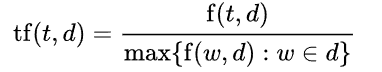

* Thương của số lần xuất hiện 1 từ trong văn bản và số lần xuất hiện nhiều nhất của một từ bất kỳ trong văn bản đó. (giá trị sẽ thuộc khoảng [0, 1])
* f(t,d) - số lần xuất hiện từ t trong văn bản d.
* max{f(w,d):w∈d} - số lần xuất hiện nhiều nhất của một từ bất kỳ trong văn bản.

# IDF – inverse document frequency
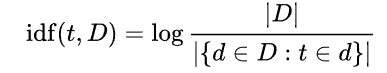

* Tử số: - tổng số văn bản trong tập D
* Mẫu số: - số văn bản chứa từ nhất định
* Giá trị TF-IDF là tích của TF và IDF

In [ ]:
#ngram: chặn dưới và chặn trên của dãy giá trị n cho các n gam khác nhau sẽ được trích xuất. 
#Tất cả các giá trị của n sao cho min_n <= n <= max_n sẽ được sử dụng.
#min_df: ngưỡng tần suất chọn dữ liệu

tfidf_description = TfidfVectorizer(ngram_range=(1, 3), min_df=5, max_features=500000)
train_description = tfidf_description.fit_transform(df_train['preprocess_item_description'])
test_description = tfidf_description.transform(df_test['preprocess_item_description'])


tfidf_name = TfidfVectorizer(ngram_range=(1, 3), min_df=3, max_features=250000)
train_name = tfidf_name.fit_transform(df_train['name'])
test_name = tfidf_name.transform(df_test['name'])

In [ ]:
train_description.shape

In [ ]:
#binarize các nhãn
lb_item_condition_id = preprocessing.LabelBinarizer(sparse_output=True)
#lưu data vào RAM
train_condition = lb_item_condition_id.fit_transform(df_train['item_condition_id'])
#lưu data vào RAM
test_condition = lb_item_condition_id.transform(df_test['item_condition_id'])
train_condition.shape

In [ ]:
lb_shipping = preprocessing.LabelBinarizer(sparse_output=True)
train_shipping = lb_shipping.fit_transform(df_train['shipping'])
test_shipping = lb_shipping.transform(df_test['shipping'])
train_shipping.shape

In [ ]:
lb_brand_name = preprocessing.LabelBinarizer(sparse_output=True)
train_brand_name= lb_brand_name.fit_transform(df_train['brand_name'])
test_brand_name = lb_brand_name.transform(df_test['brand_name'])
train_brand_name.shape

In [ ]:
lb_sub1 = preprocessing.LabelBinarizer(sparse_output=True)
train_sub1 = lb_sub1.fit_transform(df_train['sub1'])
test_sub1 = lb_sub1.transform(df_test['sub1'])
train_sub1.shape

In [ ]:
lb_sub2 = preprocessing.LabelBinarizer(sparse_output=True)
train_sub2 = lb_sub2.fit_transform(df_train['sub2'])
test_sub2 = lb_sub2.transform(df_test['sub2'])
train_sub2.shape

In [ ]:
lb_sub3 = preprocessing.LabelBinarizer(sparse_output=True)
train_sub3 = lb_sub3.fit_transform(df_train['sub3'])
test_sub3 = lb_sub3.transform(df_test['sub3'])
train_sub3.shape

In [ ]:
#ma trận hóa dữ liệu 
train = hstack((train_name, train_description, 
             train_brand_name,train_condition, train_shipping,
                      train_sub1, train_sub2, train_sub3)).tocsr()

In [ ]:
train.shape

# 5. Lựa chọn hàm lỗi và đánh giá mô hình
a. Hàm lỗi RMSLE


$$\sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }$$

$n$ là tổng số quan sát trong tập dữ liệu 

$p_i$ là dự đoán của 

$a_i$ là mục tiêu thực tế cho i

$log_e(x)$ là lôgarit tự nhiên của   $x(log_e(x)$

Lý do lựa chọn: nhằm giảm thiểu các giá trị ngoại lệ xuất hiện trong một số loại mặt hàng

In [ ]:
def rmsle(y, y_pred):
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate(y, y_pred):
    return rmsle(np.expm1(y), np.expm1(y_pred))

In [ ]:
#hàm train model
def model_train_predict(model, X):
    #chia bộ train và test với 30% test size 
    X_train, X_test, y_train, y_test = train_test_split(X, df_train['price'], test_size=0.3,random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred, y_test

In [ ]:
ridge = Ridge()

b. Model Ridge()

$$\mathcal{L}(\mathbf{w}) = \frac{1}{N} \sum_{i=1}^{N} (y_i - \mathbf{w}^{\intercal}\mathbf{x}_i) = \frac{1}{N}||\bar{\mathbf{X}}\mathbf{w} - \mathbf{y}||_{2}^{2}$$
*  Lý do lựa chọn: 
Các vấn đề phân loại văn bản do việc dữ liệu có nhiều chiều không gian khả năng được phân tách tuyến tính

Mô hình Rigde có thể giải quyết data có tính phi tuyến tính cao và dễ bị over-fitting. Có thể có một bộ phân loại phi tuyến tính cung cấp hiệu suất tổng quát hóa tốt hơn so với mô hình tuyến tính tốt nhất, nhưng quá khó để ước tính các tham số đó bằng cách sử dụng mẫu dữ liệu train hữu hạn. Trong thực tế, mô hình càng đơn giản thì càng ít gặp vấn đề trong việc ước lượng các tham số, do đó ít có xu hướng over-fitting.

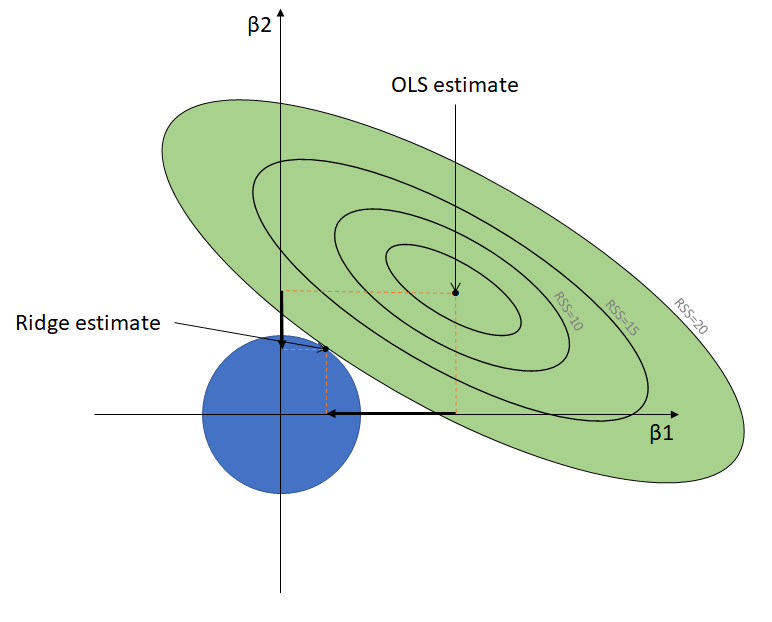

In [ ]:
y_pred, y_test = model_train_predict(ridge, train)

In [ ]:
rmsle_Ridge = evaluate(y_test, y_pred)
rmsle_Ridge

In [ ]:
new_test = (test_name, test_description, test_brand_name, 
                      test_condition, test_shipping, 
                      test_sub1, test_sub2, test_sub3)
X_test = hstack(new_test).tocsr()

In [ ]:
preds = ridge.predict(X_test)
preds = np.expm1(preds)

In [ ]:
submission = pd.read_csv('sample_submission_stg2.csv')
submission
submission.loc[:, 'price'] = preds
submission

In [ ]:
submission.to_csv('submission.csv', index=False)